# 1. Load the CIFAR-10 dataset

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


####################################################################################################
# # Extract X_train, y_train, X_test, y_test
# X_train = []
# y_train = []
# for images, labels in trainloader:
#     X_train.append(images)
#     y_train.append(labels)

# X_test = []
# y_test = []
# for images, labels in testloader:
#     X_test.append(images)
#     y_test.append(labels)

# # Convert to tensors
# X_train = torch.cat(X_train, dim=0)
# y_train = torch.cat(y_train, dim=0)
# X_test = torch.cat(X_test, dim=0)
# y_test = torch.cat(y_test, dim=0)

# # Print shapes
# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")

Files already downloaded and verified
Files already downloaded and verified


# 2. Define the CNN architecture

Files already downloaded and verified
Files already downloaded and verified
Starting architecture exploration...

Testing architecture with 1 conv layers, 1 dense layers, and learning rate 0.0001
Progress: Task 1/18
Epoch [1/5]
Test Acc: 53.21%
Epoch [2/5]
Test Acc: 58.30%
Epoch [3/5]
Test Acc: 60.22%
Epoch [4/5]
Test Acc: 62.57%
Epoch [5/5]
Test Acc: 65.06%
Task completed in 1.1 minutes

Testing architecture with 1 conv layers, 1 dense layers, and learning rate 0.00037
Progress: Task 2/18
Estimated total time remaining: 139.4 minutes
Estimated completion time: 15:06:34
Epoch [1/5]
Test Acc: 49.00%
Epoch [2/5]
Test Acc: 55.15%
Epoch [3/5]
Test Acc: 58.86%
Epoch [4/5]
Test Acc: 60.79%
Epoch [5/5]
Test Acc: 62.59%
Task completed in 1.1 minutes

Testing architecture with 1 conv layers, 1 dense layers, and learning rate 0.001
Progress: Task 3/18
Estimated total time remaining: 134.0 minutes
Estimated completion time: 15:02:14
Epoch [1/5]
Test Acc: 43.37%
Epoch [2/5]
Test Acc: 46.04%
Epoch 

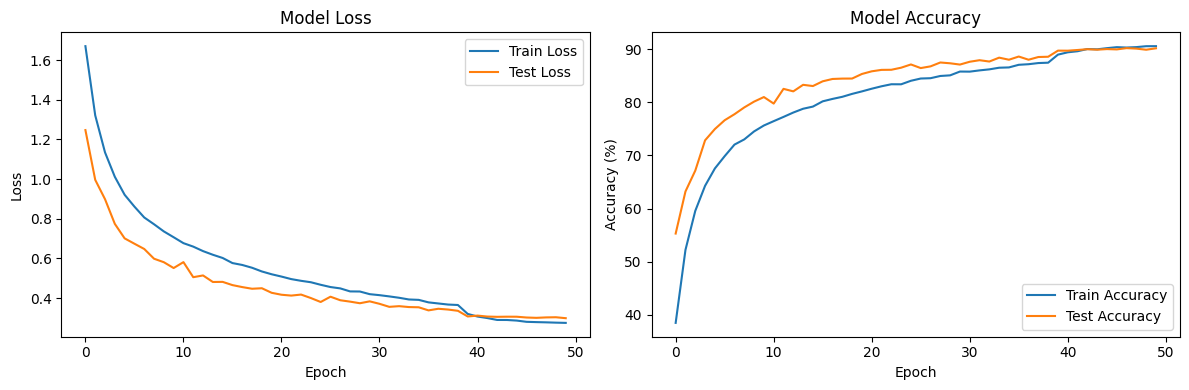

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rates = [0.0001, 0.00037, 0.001]  # Adding learning rate search

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                       shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

class CIFAR10CNN(nn.Module):
    def __init__(self, num_conv_layers=3, num_dense_layers=2):
        super(CIFAR10CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        
        # Define convolutional layers dynamically
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        conv_channels = [64, 128, 256]  # Channels for each conv layer
        
        for i in range(num_conv_layers):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, conv_channels[i], kernel_size=3, padding=1),
                nn.BatchNorm2d(conv_channels[i]),
                nn.ReLU(),
                nn.Conv2d(conv_channels[i], conv_channels[i]*2, kernel_size=3, padding=1),
                nn.BatchNorm2d(conv_channels[i]*2),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Dropout2d(0.2 + 0.1*i)  # Progressive dropout
            )
            self.conv_layers.append(conv_block)
            in_channels = conv_channels[i]*2
        
        # Calculate input size for dense layers
        self.flatten_size = conv_channels[num_conv_layers-1]*2 * (32 // (2**num_conv_layers))**2
        
        # Define dense layers dynamically
        self.dense_layers = nn.ModuleList()
        dense_sizes = [512, 256]  # Sizes for dense layers
        
        in_features = self.flatten_size
        for i in range(num_dense_layers):
            self.dense_layers.append(nn.Linear(in_features, dense_sizes[i]))
            self.dense_layers.append(nn.ReLU())
            self.dense_layers.append(nn.Dropout(0.4 + 0.1*i))
            in_features = dense_sizes[i]
        
        # Final classification layer
        self.classifier = nn.Linear(in_features, 10)

    def forward(self, x):
        # Pass through conv layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # Pass through dense layers
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
        
        # Final classification
        x = self.classifier(x)
        return x

def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def estimate_total_time(total_tasks, avg_time_per_task, num_epochs):
    # Estimate architecture exploration time
    exploration_time = total_tasks * avg_time_per_task * 5  # 5 epochs per architecture
    
    # Estimate final training time
    final_training_time = avg_time_per_task * num_epochs  # Full training epochs
    
    total_remaining = exploration_time + final_training_time
    return total_remaining

def explore_architectures():
    results = []
    
    total_tasks = len(range(1, 4)) * len(range(1, 3)) * len(learning_rates)  # Including learning rate search
    current_task = 0
    total_time = 0
    
    for conv_layers in range(1, 4):
        for dense_layers in range(1, 3):
            for lr in learning_rates:  # Adding learning rate search
                current_task += 1
                task_start_time = time.time()
                
                print(f"\nTesting architecture with {conv_layers} conv layers, {dense_layers} dense layers, and learning rate {lr}")
                print(f"Progress: Task {current_task}/{total_tasks}")
                
                if current_task > 1:
                    avg_time_per_task = total_time / (current_task - 1)
                    remaining_tasks = total_tasks - current_task
                    
                    # Estimate total remaining time including final training
                    total_remaining = estimate_total_time(remaining_tasks, avg_time_per_task, num_epochs)
                    print(f"Estimated total time remaining: {total_remaining/60:.1f} minutes")
                    print(f"Estimated completion time: {time.strftime('%H:%M:%S', time.localtime(time.time() + total_remaining))}")
                
                # Initialize model with current architecture
                model = CIFAR10CNN(
                    num_conv_layers=conv_layers,
                    num_dense_layers=dense_layers
                ).to(device)
                
                # Initialize optimizer and criterion
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
                criterion = nn.CrossEntropyLoss()
                
                # Train for a few epochs to evaluate architecture
                best_acc = 0
                for epoch in range(5):  # Quick evaluation with 5 epochs
                    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
                    test_loss, test_acc = test(model, testloader, criterion, device)
                    scheduler.step()
                    
                    best_acc = max(best_acc, test_acc)
                    
                    print(f'Epoch [{epoch+1}/5]')
                    print(f'Test Acc: {test_acc:.2f}%')
                
                task_time = time.time() - task_start_time
                total_time += task_time
                print(f"Task completed in {task_time/60:.1f} minutes")
                
                results.append({
                    'conv_layers': conv_layers,
                    'dense_layers': dense_layers,
                    'learning_rate': lr,
                    'best_acc': best_acc
                })
    
    # Find best architecture
    best_result = max(results, key=lambda x: x['best_acc'])
    print("\nBest architecture found:")
    print(f"Conv layers: {best_result['conv_layers']}")
    print(f"Dense layers: {best_result['dense_layers']}")
    print(f"Learning rate: {best_result['learning_rate']}")
    print(f"Accuracy: {best_result['best_acc']:.2f}%")
    
    return best_result

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Run architecture exploration
print("Starting architecture exploration...")
best_architecture = explore_architectures()

# Train final model with best architecture
print("\nTraining final model with best architecture...")
final_model = CIFAR10CNN(
    num_conv_layers=best_architecture['conv_layers'],
    num_dense_layers=best_architecture['dense_layers']
).to(device)

# Initialize for final training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_architecture['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop
print(f"Training on {device}")
best_acc = 0.0
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss, train_acc = train(final_model, trainloader, criterion, optimizer, device)
    test_loss, test_acc = test(final_model, testloader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    scheduler.step(test_acc)
    
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(final_model.state_dict(), 'best_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Time: {time.time() - start_time:.2f}s\n')
    
    # Early stopping
    early_stopping(test_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# Load and evaluate the model
model = CIFAR10CNN(num_conv_layers=3, num_dense_layers=1).to(device)  # Corrected to match best architecture
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize counters
class_correct = [0 for _ in range(10)]
class_total = [0 for _ in range(10)]
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize total counters
total_correct = 0
total_samples = 0

# Evaluate
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            total_correct += c[i].item()
            total_samples += 1

# Print results
for i in range(10):
    if class_total[i] > 0:
        print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    else:
        print(f'Accuracy of {class_names[i]}: N/A (no samples)')

# Print total accuracy
if total_samples > 0:
    print(f'Total Accuracy: {100 * total_correct / total_samples:.2f}%')
else:
    print('Total Accuracy: N/A (no samples)')

/tmp/ipykernel_48715/1003097808.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy of plane: 91.90%
Accuracy of car: 95.60%
Accuracy of bird: 82.20%
Accuracy of cat: 75.60%
Accuracy of deer: 92.70%
Accuracy of dog: 86.50%
Accuracy of frog: 94.60%
Accuracy of horse: 92.60%
Accuracy of ship: 95.00%
Accuracy of truck: 95.10%
Total Accuracy: 90.18%
